In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulation settings

In [7]:
from utils.hexec import create_estimator_options
from utils.hexec import ExecDB

L_arr = [8]
# L_arr = [8]
J = 1
h = 0.05
lamb = 0.7
g = 5

x_basis = False

particle_pair_left_positions = [L//2 - 1 for L in L_arr]
particle_pair_length = 1

final_time = 8
steps = 35

shots = [50000]

execution_database = "z2_chain_jobs_postselection.json"
job_db = ExecDB(execution_database)

circ_folder_path = "Circuits/"

# Device selection

In [8]:
from qiskit_ibm_runtime import QiskitRuntimeService
from cobos.tokens import ibm_token, group_instance, group_instance2
# from fradm.tokens import ibm_token, group_instance

channel = "ibm_quantum"
device = "ibm_kyiv"
# device = "ibm_brisbane"
# device = "ibm_fez"
# device = "ibm_sherbrooke"
# device = "ibm_torino"

eplg_absolute =  3.93e-3 

service = QiskitRuntimeService(channel=channel, token=ibm_token, instance=group_instance2)
backend = service.backend(device)

# Circuit transpilation, observables & postselection

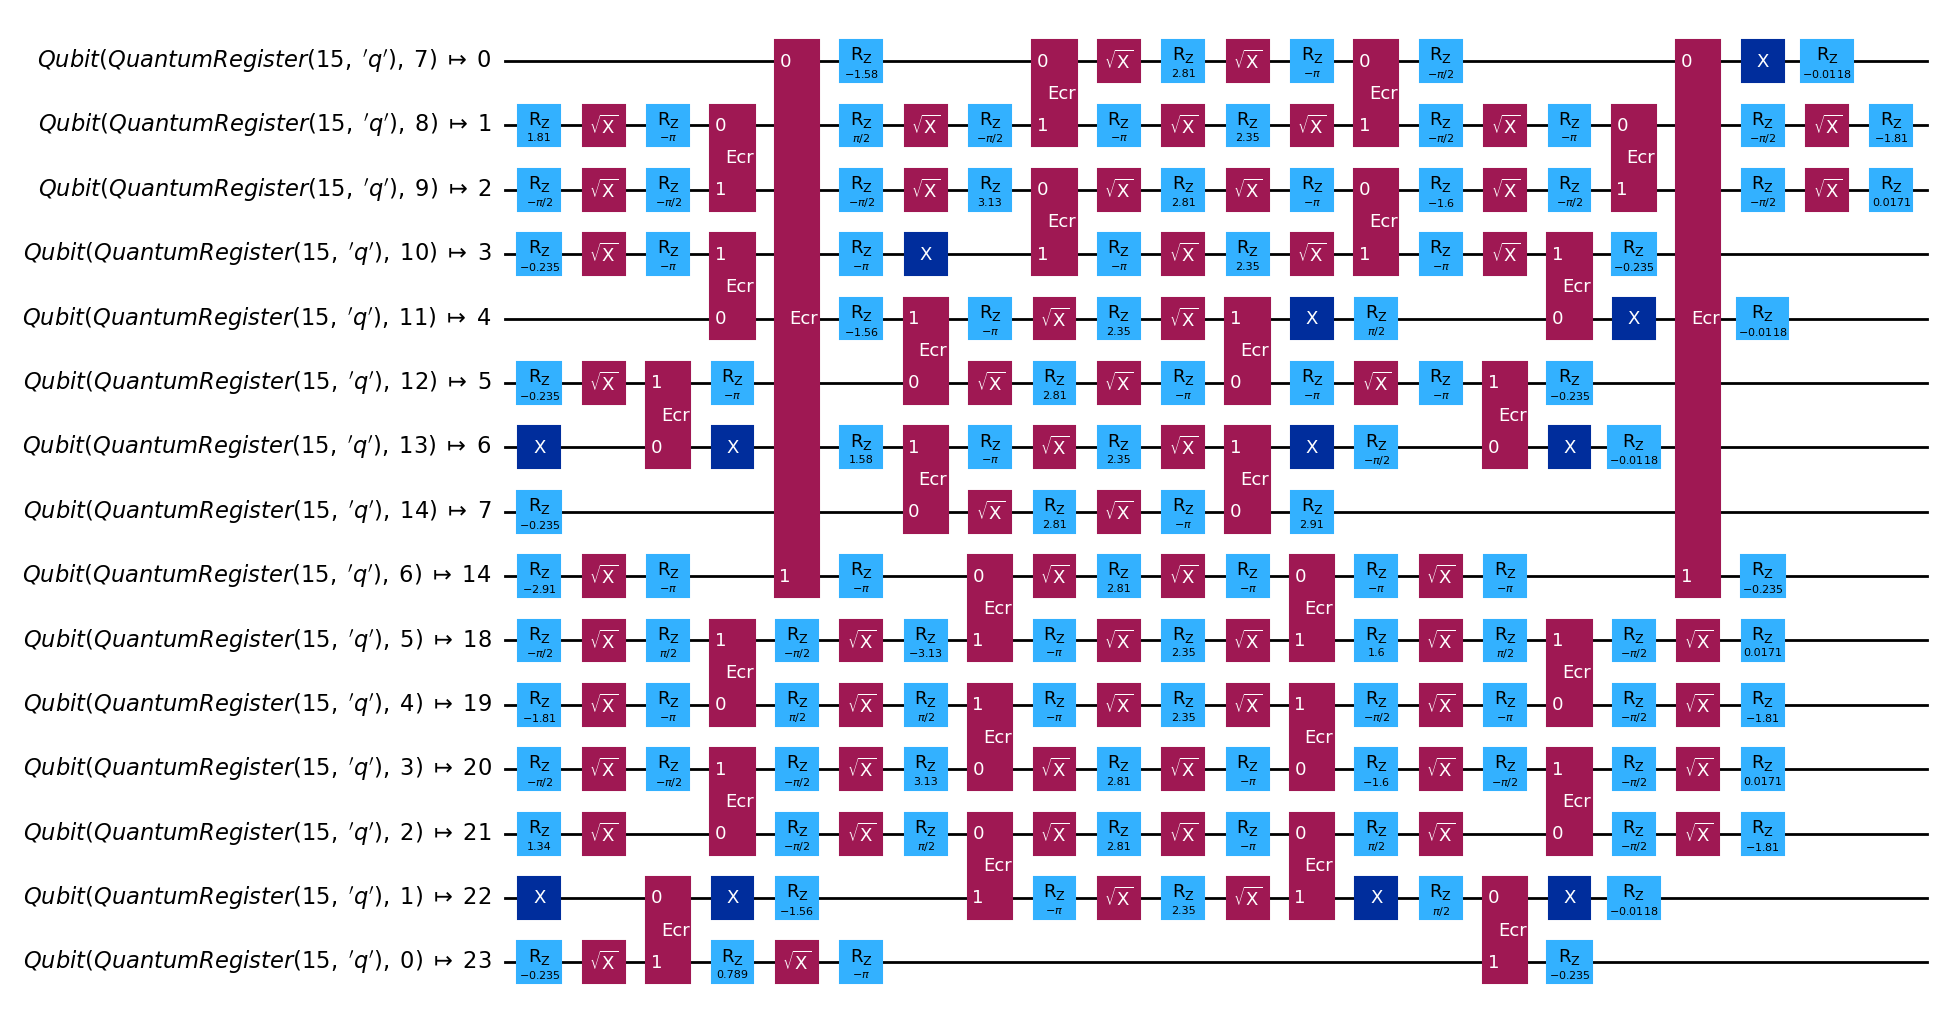

In [9]:
from z2chain.circs import physical_particle_pair_quench_simulation_circuits, erradj_particle_pair_quench_simulation_circuits
from z2chain.operators import local_pauli_z, local_pauli_x, postselection_operators
from utils.hexec import get_backend_best_qubit_chain
from utils.circs import generate_and_save_circs
from functools import partial
import os

optimization_level = 2

circuits = [] # circuits[L][t]
observable_generating_funcs = [] #observable_generating_funcs[L][i]
postselection_operators_funcs = []

sampler_options = [{
    "default_shots": nshots,
    "execution": {
        "init_qubits": True,
        "meas_type": "classified"
    },
    "dynamical_decoupling": {
        "enable": True,
        "sequence_type": "XY4"
    },
    "twirling": {
        "enable_gates": True,
        "enable_measure": True,
        "num_randomizations": "auto",
        "shots_per_randomization": "auto"
    }
} for nshots in shots]

extra_options = [{"backend": device, "L": L, "J": J, "h": h, "λ":lamb, "g": g, "particle_pair_position": pp_pos, "particle_pair_length": particle_pair_length, "final_time": final_time, "eplg": eplg_absolute} for L, pp_pos in zip(L_arr, particle_pair_left_positions)]

for L, pp_ps in zip(L_arr, particle_pair_left_positions):
    circuits_filepath = os.path.join(circ_folder_path, f"z2chain_quench_circs_{device}_maxt_{final_time}_steps_{steps}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g}_pp_{pp_ps}_pl_{particle_pair_length}_xbasis_{x_basis}.qpy")
    qubits_inds = get_backend_best_qubit_chain(backend, 2*L-1)
    circs_func_args = (L, J, h, lamb, pp_ps, particle_pair_length, final_time, steps, backend, optimization_level, eplg_absolute, g, qubits_inds, x_basis)
    physical_circuits = generate_and_save_circs(circuits_filepath, erradj_particle_pair_quench_simulation_circuits, *circs_func_args)
    observable_generating_funcs.append([partial(local_pauli_z if not x_basis else local_pauli_x, qubit_ind=i) for i in range(2*L-1)])
    postselection_operators_funcs.append(lambda nqubits: postselection_operators((nqubits + 1)//2, x_basis))
    circuits.append(physical_circuits)

circuits[0][1].draw(output="mpl", idle_wires=False)

# Post-selected circuit execution

### Send jobs to hardware

In [20]:
from utils.postselection import execute_postselected_sampler_batch

jobs = [] #jobs[L][opts][i]

for i, L in enumerate(L_arr):
    this_L_jobs = []
    for opts_dict in sampler_options:
        this_jobs = execute_postselected_sampler_batch(backend, opts_dict, circuits[i], postselection_operators_funcs[i], observable_generating_funcs[i], extra_options=extra_options[i], job_db=job_db)
        this_L_jobs.append(this_jobs)
    jobs.append(this_L_jobs)

### Load jobs with the same options

In [10]:
from utils.postselection import load_postselected_jobs

jobs = [] #jobs[L][opts][i]
samples_dicts = [] #samples_dicts[L][opts][i]
postselected_samples_dicts = [] #postselected_samples_dicts[L][opts][i]

for i, L in enumerate(L_arr):
    this_L_jobs = []
    this_L_samples_dicts = []
    this_L_postselected_samples_dicts = []
    for opts_dict in sampler_options:
        clean_extra_options = extra_options[i].copy()
        del clean_extra_options["eplg"]
        this_jobs, this_samples_dicts, this_postselected_samples_dicts = load_postselected_jobs(job_db, service, opts_dict, circuits[i], postselection_operators_funcs[i], observable_generating_funcs[i], clean_extra_options, return_samples_dicts=True, return_postselected_samples_dicts=True)
        this_L_jobs.append(this_jobs)
        this_L_samples_dicts.append(this_samples_dicts)
        this_L_postselected_samples_dicts.append(this_postselected_samples_dicts)
    jobs.append(this_L_jobs)
    samples_dicts.append(this_L_samples_dicts)
    postselected_samples_dicts.append(this_L_postselected_samples_dicts)

### Load batch jobs into the database

In [5]:
# from utils.postselection import db_add_postselected_sampler_ran_batch

# batch_ids = [['cwbsyhj9ezk000892fe0', 'cwbsz54jzdhg0089x0qg', 'cwbsztzbhxtg008sfhbg', 'cwbt0gabhxtg008sfhjg', 'cwbt18n9ezk000892g4g', 'cwbt1yfjzdhg0089x1n0', 'cwbt2jt2802g008604h0', 'cwbt38n2802g008604q0']]
# batch_ids = [['cwbtmtkjzdhg0089x440', 'cwbtnf5jzdhg0089x4ag', 'cwbtp5gbhxtg008sfmtg', 'cwbtpv3jzdhg0089x4ng', 'cwbtqjpbhxtg008sfn50', 'cwbtrmtggr6g00890cmg', 'cwbtscxbhxtg008sfngg', 'cwbtt482802g008608g0']]
# batch_ids = [['cwbv1tq9ezk000892mw0', 'cwbv2ka9ezk000892n5g', 'cwbv395jzdhg0089x6g0', 'cwbv3zzggr6g00890e20', 'cwbv4w3jzdhg0089x6vg', 'cwbv5pe9ezk000892p30', 'cwbv6gtbhxtg008sfqs0', 'cwbv7cdbhxtg008sfr10']]
# batch_ids = [['cwbw24g2802g00860dw0', "cwbw2z3ggr6g00890j9g", 'cwbw3mp2802g00860e7g', 'cwbw491jzdhg0089xbbg', 'cwbw4zvjzdhg0089xbk0', 'cwbw5npggr6g00890jx0', 'cwbw6eh2802g00860ez0', 'cwbw7cd9ezk000892txg']]

# for i, L in enumerate(L_arr):
#     for j, opts_dict in enumerate(sampler_options):
#         db_add_postselected_sampler_ran_batch(job_db, service, batch_ids[j][i], backend, opts_dict, circuits[i], postselection_operators_funcs[i], observable_generating_funcs[i], extra_options[i])

# Plots

### Quech plot

In [24]:
jobs[0][0][5, :]

array([ 0.7660485 ,  0.7660485 ,  0.73149469,  0.6427326 ,  0.23041158,
        0.16901781, -0.17789401, -0.62656522, -0.15528082,  0.21868231,
        0.220056  ,  0.97706979,  0.99038411,  0.98499498,  0.98499498])

L = 8 / Options = 0


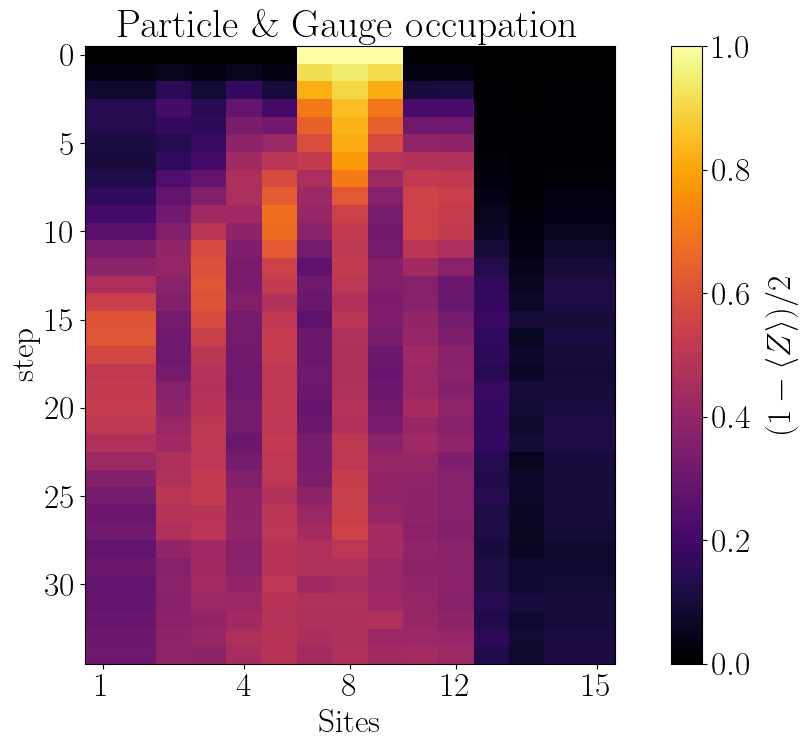

In [14]:
from z2chain.plotting import x_t_plot

for i, L in enumerate(L_arr):
    for j, opts_dict in enumerate(sampler_options):
        print(f"L = {L} / Options = {j}")
        occupations = (1-jobs[i][j])/2
        x_t_plot(occupations, filepath=f"Plots/hardware_postselection_z2pairquench_maxt_{final_time}_steps_{steps}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g}_pp_{particle_pair_left_positions[i]}_pl_{particle_pair_length}_dc_{opts_dict["dynamical_decoupling"]["sequence_type"]}_xbasis_{x_basis}.png")

In [ ]:
from z2chain.plotting import plot_n_discarded_samples
from utils.circs import depth2qb
import numpy as np

for i, L in enumerate(L_arr):
    for j, opts_dict in enumerate(sampler_options):
        plot_n_discarded_samples(samples_dicts[i][j], postselected_samples_dicts[i][j], x_arr=np.array([depth2qb(circ) for circ in circuits[i]]), xlabel="2Qb Depth", regression=True, filepath=f"postselected_samples_maxt_{final_time}_steps_{steps}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g}_pp_{particle_pair_left_positions[i]}_pl_{particle_pair_length}_dc_{sampler_options["dynamical_decoupling"]["sequence_type"]}_xbasis_{x_basis}.png.png")